# Proyecto: Segmentación de Defectos Superficiales con YOLO11

## 1. Definición del Problema
El objetivo es detectar y segmentar defectos en superficies utilizando un dataset limitado. Se empleará **Transfer Learning** para adaptar un modelo SOTA (State of the Art) a nuestras necesidades específicas.

## 2. Selección del Modelo
Se ha seleccionado la arquitectura **YOLO11-seg** (versión Small), la iteración más reciente de la familia YOLO mantenida por Ultralytics.
* **Modelo Base:** `yolo11s-seg.pt`
* **Arquitectura:** Introduce mejoras en el bloque C3k2 y un diseño de cabecera más eficiente comparado con v8.
* **Justificación:** YOLO11 ofrece una mejor relación precisión-rendimiento (Efficiency-Accuracy trade-off) que sus predecesores, permitiendo una detección más fina de defectos pequeños con menor coste computacional.

## 3. Estrategia de Entrenamiento
* **División de Datos:** 75% Train / 25% Val (Estratificado por presencia de defecto).
* **Augmentation:** Crítico para la variabilidad del dataset (Mosaic, Mixup).
* **Entorno:** WSL (Ubuntu) + GPU.

In [3]:
# 1. Instalación de librerías necesarias
# Usamos -q (quiet) para que no llene la pantalla de texto, y opencv-python-headless es mejor para entornos WSL/Servidor
print("Instalando dependencias... espera un momento.")
#%pip install -q ultralytics scikit-learn matplotlib opencv-python-headless tqdm

# 2. Importaciones clave
import os
import shutil
import random
import yaml
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from pathlib import Path
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from tqdm import tqdm

# 3. Verificación de Hardware (GPU Check)
print("\n" + "="*30)
print("VERIFICACIÓN DE ESTADO DEL SISTEMA")
print("="*30)

# Chequeo de PyTorch y CUDA
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Disponible: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Tarjeta Gráfica Detectada: {torch.cuda.get_device_name(0)}")
    print(f"VRAM Disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ ALERTA: No se detecta GPU. El entrenamiento será MUY lento.")
    print("Si tienes GPU NVIDIA, asegúrate de tener los drivers instalados en Windows y CUDA Toolkit configurado.")

# Chequeo de Ultralytics
print("\nChequeo de Ultralytics:")
import ultralytics
ultralytics.checks()

Ultralytics 8.3.235 🚀 Python-3.12.3 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Setup complete ✅ (16 CPUs, 15.5 GB RAM, 112.7/1006.9 GB disk)


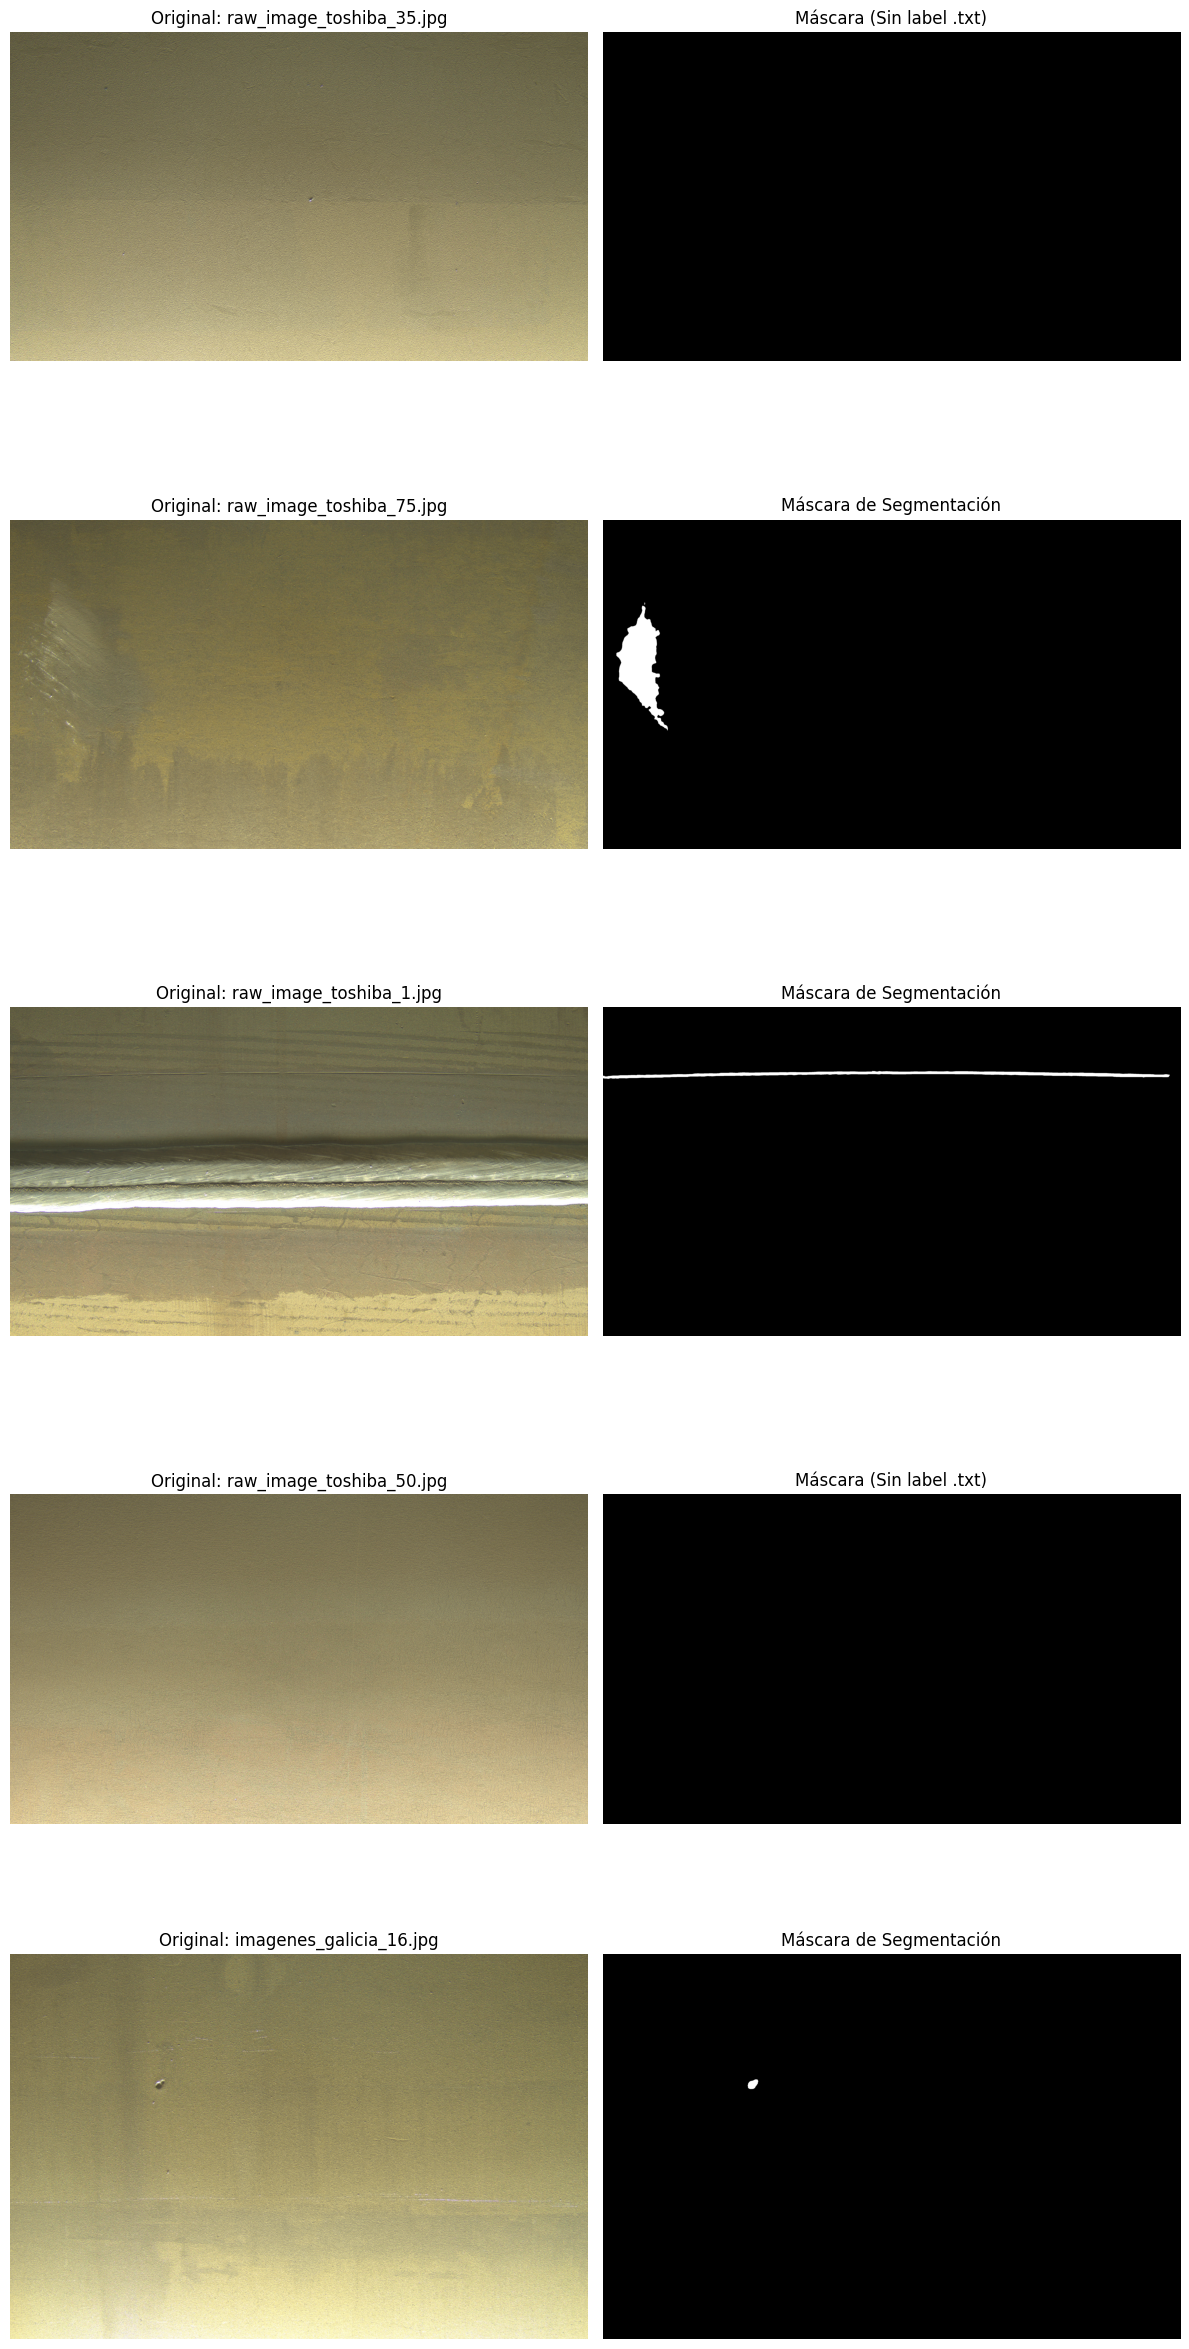

In [15]:
# 1. Configura tus rutas
# Asegúrate de que estas rutas apunten correctamente a tus carpetas 'images' y 'labels'
# según donde esté tu notebook.
base_dir = Path("galicia_segmentation") 
images_dir = base_dir / "images/train"
labels_dir = base_dir / "labels/train"

def visualizar_original_y_mascara(num_samples=2):
    # Verificaciones básicas
    if not images_dir.exists() or not labels_dir.exists():
        print(f"❌ Error: Rutas no encontradas en {base_dir.absolute()}")
        return

    # Listar imágenes
    image_files = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png")) + list(images_dir.glob("*.jpeg"))
    if not image_files:
        print("❌ No se encontraron imágenes.")
        return

    # Seleccionar aleatoriamente
    selected_files = random.sample(image_files, min(num_samples, len(image_files)))

    # Configurar el plot: 'num_samples' filas, 2 columnas (Original | Máscara)
    plt.figure(figsize=(12, 5 * num_samples))

    for i, img_path in enumerate(selected_files):
        # 2. Cargar Imagen Original
        img = cv2.imread(str(img_path))
        if img is None: continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # 3. Crear una imagen negra para la máscara
        # Creamos una imagen de 3 canales (RGB) completamente negra ( ceros)
        mask_img = np.zeros((h, w, 3), dtype=np.uint8)

        # 4. Buscar y procesar label
        label_filename = img_path.stem + ".txt"
        label_path = labels_dir / label_filename
        
        mask_title = "Máscara (Sin label .txt)"

        if label_path.exists():
            mask_title = "Máscara de Segmentación"
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                data = line.strip().split()
                # data[0] es la clase, data[1:] son las coordenadas
                coords = list(map(float, data[1:]))
                
                # Des-normalizar coordenadas
                points = []
                for j in range(0, len(coords), 2):
                    px = int(coords[j] * w)
                    py = int(coords[j+1] * h)
                    points.append([px, py])
                
                points = np.array(points, np.int32)
                points = points.reshape((-1, 1, 2))
                
                # --- DIBUJAR EN LA MÁSCARA ---
                # Rellenar el polígono de BLANCO (255,255,255) sobre el fondo negro
                cv2.fillPoly(mask_img, [points], color=(255, 255, 255))

        # 5. Plotear (Lado izquierdo: Original, Lado derecho: Máscara)
        
        # Subplot Izquierdo (Imagen Original)
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Original: {img_path.name}")
        plt.axis("off")
        
        # Subplot Derecho (Máscara Generada)
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask_img)
        plt.title(mask_title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Ejecutar la función
visualizar_original_y_mascara(num_samples=5)


In [26]:
import os
import shutil
import random
import yaml
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

# --- CONFIGURACIÓN ---
# Rutas origen (Basadas en tu imagen)
base_origen = Path("datasets/galicia_segmentation")
src_images = base_origen / "images" / "train"  # Aquí es donde está todo ahora
src_labels = base_origen / "labels" / "train"

# Ruta destino (Nueva carpeta limpia)
dest_base = Path("datasets/final_dataset")

# Tus clases (Sacadas de tu data.yaml en la imagen)
CLASES = {0: 'pit', 1: 'scratch', 2: 'mechanical damage'}

def organizar_dataset_maestro():
    # 1. Limpiar destino si existe para evitar mezclas
    if dest_base.exists():
        print(f"⚠️ Borrando versión anterior en {dest_base} para empezar limpio...")
        shutil.rmtree(dest_base)
    
    # Crear estructura YOLO
    for split in ['train', 'val', 'test']:
        (dest_base / split / 'images').mkdir(parents=True, exist_ok=True)
        (dest_base / split / 'labels').mkdir(parents=True, exist_ok=True)

    # 2. Escanear qué tenemos
    print("🧐 Analizando archivos...")
    # Buscamos imágenes (jpg, png, etc.)
    all_images = list(src_images.glob("*.*"))
    all_images = [x for x in all_images if x.suffix.lower() in ['.jpg', '.png', '.jpeg', '.bmp']]
    
    if not all_images:
        print("❌ ERROR: No encontré imágenes en datasets/galicia_segmentation/images/train")
        return

    # Agrupar por clase para estratificar
    # (Si una imagen tiene varios defectos, la asignamos al primero que encontremos para simplificar el split)
    grouped_files = defaultdict(list)
    clean_files = [] # Imágenes sin defectos (background)

    for img_path in tqdm(all_images, desc="Clasificando"):
        label_file = src_labels / (img_path.stem + ".txt")
        
        has_defect = False
        primary_class = -1
        
        if label_file.exists():
            with open(label_file, 'r') as f:
                lines = f.readlines()
                if lines:
                    # Leemos la clase de la primera línea
                    first_class = int(lines[0].split()[0])
                    grouped_files[first_class].append(img_path)
                    has_defect = True
        
        if not has_defect:
            clean_files.append(img_path)

    # 3. Repartir (Split 70/15/15)
    splits = {'train': 0.7, 'val': 0.15, 'test': 0.15}
    
    print("\n📦 Moviendo archivos a la nueva estructura...")
    
    # Función auxiliar para repartir una lista de imágenes
    def distribuir_lista(lista_imgs, nombre_grupo):
        random.shuffle(lista_imgs)
        total = len(lista_imgs)
        n_train = int(total * 0.7)
        n_val = int(total * 0.15)
        # El resto a test
        
        splits_files = {
            'train': lista_imgs[:n_train],
            'val':   lista_imgs[n_train:n_train+n_val],
            'test':  lista_imgs[n_train+n_val:]
        }
        
        for split, files in splits_files.items():
            for img in files:
                # Copiar Imagen
                shutil.copy(img, dest_base / split / 'images' / img.name)
                
                # Copiar Label (si existe)
                lbl_src = src_labels / (img.stem + ".txt")
                lbl_dst = dest_base / split / 'labels' / (img.stem + ".txt")
                
                if lbl_src.exists():
                    shutil.copy(lbl_src, lbl_dst)
                else:
                    # Crear vacío si es 'clean' (importante para YOLO)
                    with open(lbl_dst, 'w') as f:
                        pass
        
        print(f"   -> {nombre_grupo}: Total {total} (Train: {len(splits_files['train'])}, Val: {len(splits_files['val'])}, Test: {len(splits_files['test'])})")

    # Procesar cada clase por separado
    for class_id, name in CLASES.items():
        if class_id in grouped_files:
            distribuir_lista(grouped_files[class_id], f"Clase {name}")
        else:
            print(f"⚠️ Advertencia: No encontré imágenes de la clase '{name}'")
            
    # Procesar imágenes limpias (si hay)
    if clean_files:
        distribuir_lista(clean_files, "Background (Limpias)")

    # 4. Crear el YAML Definitivo automáticamente
    final_yaml = {
        'path': str(dest_base.absolute()), # Ruta absoluta vital
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 3,
        'names': CLASES
    }
    
    yaml_path = dest_base / "data_final.yaml"
    with open(yaml_path, 'w') as f:
        yaml.dump(final_yaml, f, sort_keys=False)

    print("-" * 30)
    print(f"✅ ¡Listo! Dataset organizado en: {dest_base}")
    print(f"📄 Archivo YAML creado en: {yaml_path}")
    return str(yaml_path)

# EJECUTAR
nuevo_yaml = organizar_dataset_maestro()

⚠️ Borrando versión anterior en datasets/final_dataset para empezar limpio...
🧐 Analizando archivos...


Clasificando: 100%|██████████| 103/103 [00:00<00:00, 21387.86it/s]


📦 Moviendo archivos a la nueva estructura...


   -> Clase pit: Total 15 (Train: 10, Val: 2, Test: 3)
   -> Clase scratch: Total 7 (Train: 4, Val: 1, Test: 2)
   -> Clase mechanical damage: Total 17 (Train: 11, Val: 2, Test: 4)
   -> Background (Limpias): Total 64 (Train: 44, Val: 9, Test: 11)
------------------------------
✅ ¡Listo! Dataset organizado en: datasets/final_dataset
📄 Archivo YAML creado en: datasets/final_dataset/data_final.yaml


In [4]:
def comprobar_tamano_real():
    # Usamos una carpeta de ejemplo
    img_dir = Path("datasets/final_dataset/train/images")
    images = list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png"))
    
    if not images:
        print("No encuentro imágenes.")
        return

    # Miramos las primeras 5
    print(f"Analizando dimensiones de 5 imágenes aleatorias:")
    for img_path in images[:5]:
        img = cv2.imread(str(img_path))
        h, w, _ = img.shape
        print(f" - {img_path.name}: {w}x{h} píxeles")

comprobar_tamano_real()

Analizando dimensiones de 5 imágenes aleatorias:
 - imagenes_galicia_19.jpg: 5472x3648 píxeles
 - raw_image_toshiba_50.jpg: 5320x3032 píxeles
 - imagenes_galicia_26.jpg: 5472x3648 píxeles
 - raw_image_toshiba_25.jpg: 5320x3032 píxeles
 - raw_image_toshiba_44.jpg: 5320x3032 píxeles


In [7]:
from ultralytics import YOLO
import gc
import torch

# Limpiar memoria antes de empezar
gc.collect()
torch.cuda.empty_cache()

model = YOLO('yolo11n-seg.pt') 

print("🔬 Iniciando entrenamiento de ALTA RESOLUCIÓN (1024px)...")

results = model.train(
    data='datasets/final_dataset/data_final.yaml',
    
    epochs=60,         # Un poco más largo porque con batch pequeño aprende más despacio
    
    # --- CAMBIOS CLAVE ---
    imgsz=1024,        # <--- ¡Aquí está la magia! Verá los detalles pequeños
    batch=2,           # <--- Bajamos al mínimo para que aguante la resolución
    
    # Optimizaciones de memoria
    workers=1,
    amp=True,
    cache=False,
    
    project='Toshiba_Defects',
    name='train_hires_1024',
    
    # Augmentation agresivo para compensar los pocos datos
    degrees=25.0,      # Más rotación
    fliplr=0.5,
    flipud=0.5,
    mosaic=1.0,
    mixup=0.1,         # Mezclar imágenes ayuda cuando hay pocos datos
    
    patience=20,
    device=0
)

🔬 Iniciando entrenamiento de ALTA RESOLUCIÓN (1024px)...
Ultralytics 8.3.235 🚀 Python-3.12.3 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/final_dataset/data_final.yaml, degrees=25.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_hires_1024, nbs=64, nms=False, opset=No

In [8]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# --- CONFIGURACIÓN ---
src_root = Path("datasets/final_dataset")
dest_root = Path("datasets/unet_dataset")

# Mapeo de colores para las máscaras (0 es fondo negro)
# Clase 0 (Pit) -> 1
# Clase 1 (Scratch) -> 2
# Clase 2 (Damage) -> 3
CLASS_MAP = {0: 1, 1: 2, 2: 3} 

def yolo_to_mask():
    for split in ['train', 'val', 'test']:
        img_dir = src_root / split / 'images'
        lbl_dir = src_root / split / 'labels'
        
        save_img_dir = dest_root / split / 'images'
        save_mask_dir = dest_root / split / 'masks'
        
        save_img_dir.mkdir(parents=True, exist_ok=True)
        save_mask_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"🔄 Procesando {split}...")
        
        images = list(img_dir.glob("*.*"))
        
        for img_path in tqdm(images):
            # 1. Leer imagen y tamaño
            img = cv2.imread(str(img_path))
            h, w = img.shape[:2]
            
            # 2. Crear máscara negra vacía
            mask = np.zeros((h, w), dtype=np.uint8)
            
            # 3. Leer label YOLO correspondiente
            label_path = lbl_dir / (img_path.stem + ".txt")
            
            if label_path.exists():
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    
                # Dibujar polígonos
                for line in lines:
                    parts = line.strip().split()
                    cls_id = int(parts[0])
                    coords = list(map(float, parts[1:]))
                    
                    # Convertir norm -> pixeles
                    points = []
                    for i in range(0, len(coords), 2):
                        px = int(coords[i] * w)
                        py = int(coords[i+1] * h)
                        points.append([px, py])
                    
                    pts = np.array(points, np.int32).reshape((-1, 1, 2))
                    
                    # Pintar el polígono con el ID de la clase (1, 2 o 3)
                    pixel_val = CLASS_MAP.get(cls_id, 0)
                    cv2.fillPoly(mask, [pts], color=pixel_val)

            # 4. Guardar
            # Copiamos la imagen original
            cv2.imwrite(str(save_img_dir / img_path.name), img)
            # Guardamos la máscara (PNG sin compresión para no perder valores)
            cv2.imwrite(str(save_mask_dir / (img_path.stem + ".png")), mask)

    print(f"✅ Conversión terminada. Datos en: {dest_root}")

yolo_to_mask()

🔄 Procesando train...


100%|██████████| 69/69 [00:12<00:00,  5.73it/s]


🔄 Procesando val...


100%|██████████| 14/14 [00:02<00:00,  5.59it/s]


🔄 Procesando test...


100%|██████████| 20/20 [00:03<00:00,  5.26it/s]

✅ Conversión terminada. Datos en: datasets/unet_dataset


In [9]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm  # Para barra de progreso

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
TRAIN_DIR = "datasets/unet_dataset/train"
VAL_DIR = "datasets/unet_dataset/val"

# Parámetros del modelo
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 4          # 0:Fondo, 1:Pit, 2:Scratch, 3:Damage
ACTIVATION = None    # Dejar None porque usaremos CrossEntropy/Logits en la loss

# Hiperparámetros
TILE_SIZE = 1024     # Tamaño del recorte
BATCH_SIZE = 4       # Baja a 2 si te da error de memoria (CUDA Out of memory)
EPOCHS = 20
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==========================================
# 2. DEFINICIÓN DEL DATASET
# ==========================================
class IndustrialDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        
        # Listamos solo imágenes válidas
        self.images = [f for f in os.listdir(self.img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # IMPORTANTE: La máscara siempre es .png (según nuestro script anterior)
        # Quitamos la extensión de la imagen y ponemos .png
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        # 1. Cargar Imagen
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. Cargar Máscara
        # La leemos en escala de grises (0, 1, 2, 3)
        mask = cv2.imread(mask_path, 0)
        
        # Protección por si la máscara no existe (aunque debería)
        if mask is None:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # 3. Aplicar Transformaciones (Recortes)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# ==========================================
# 3. TRANSFORMACIONES (Augmentation & Tiling)
# ==========================================
# Entrenamiento: Recorte Aleatorio (Simula tiling infinito) + Flips
train_transform = A.Compose([
    A.PadIfNeeded(min_height=TILE_SIZE, min_width=TILE_SIZE, always_apply=True),
    A.RandomCrop(height=TILE_SIZE, width=TILE_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Validación: Recorte Central (Para que sea constante y comparable)
val_transform = A.Compose([
    A.PadIfNeeded(min_height=TILE_SIZE, min_width=TILE_SIZE, always_apply=True),
    A.CenterCrop(height=TILE_SIZE, width=TILE_SIZE, p=1.0), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ==========================================
# 4. PREPARAR MODELO Y ENTRENAMIENTO
# ==========================================
def main():
    print(f"🔧 Utilizando dispositivo: {DEVICE}")

    # Datasets
    train_dataset = IndustrialDataset(TRAIN_DIR, transform=train_transform)
    val_dataset = IndustrialDataset(VAL_DIR, transform=val_transform)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"📂 Datos cargados: {len(train_dataset)} Train, {len(val_dataset)} Val")

    # Modelo U-Net++
    model = smp.UnetPlusPlus(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=3,
        classes=CLASSES,
        activation=ACTIVATION,
    )
    model.to(DEVICE)

    # Loss Functions
    loss_fn_dice = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
    loss_fn_focal = smp.losses.FocalLoss(mode='multiclass')

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Loop
    best_valid_loss = float('inf')

    print("🚀 Iniciando entrenamiento...")
    
    for epoch in range(EPOCHS):
        # --- TRAIN ---
        model.train()
        train_loss = 0
        
        # Barra de progreso para Train
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
        
        for images, masks in loop:
            images = images.to(DEVICE)
            masks = masks.long().to(DEVICE) # Máscara debe ser Long (enteros)

            optimizer.zero_grad()
            
            # Predicción
            logits = model(images) 
            
            # Cálculo de Loss Híbrida
            # Focal Loss + Dice Loss
            loss = loss_fn_dice(logits, masks) + loss_fn_focal(logits, masks)
            
            # Backward
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # --- VALIDATION ---
        model.eval()
        valid_loss = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(DEVICE)
                masks = masks.long().to(DEVICE)

                logits = model(images)
                loss = loss_fn_dice(logits, masks) + loss_fn_focal(logits, masks)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss / len(val_loader)

        print(f"\n✅ Epoch {epoch+1} Resumen:")
        print(f"   Train Loss: {avg_train_loss:.4f}")
        print(f"   Valid Loss: {avg_valid_loss:.4f}")

        # Guardar el mejor modelo
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), 'best_model_unet.pth')
            print("   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'")
        
        print("-" * 30)

if __name__ == '__main__':
    main()

/home/dmore/code/TFM_David/CNN_Galicia_Toshiba/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_31200/4108565764.py:80: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=TILE_SIZE, min_width=TILE_SIZE, always_apply=True),
/tmp/ipykernel_31200/4108565764.py:90: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=TILE_SIZE, min_width=TILE_SIZE, always_apply=True),


🔧 Utilizando dispositivo: cuda
📂 Datos cargados: 69 Train, 14 Val
🚀 Iniciando entrenamiento...


Epoch 1/20 [Train]: 100%|██████████| 18/18 [41:27<00:00, 138.22s/it, loss=0.871]



✅ Epoch 1 Resumen:
   Train Loss: 1.1233
   Valid Loss: 1.4259
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 2/20 [Train]: 100%|██████████| 18/18 [40:47<00:00, 135.99s/it, loss=0.736]



✅ Epoch 2 Resumen:
   Train Loss: 0.8142
   Valid Loss: 0.8953
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 3/20 [Train]: 100%|██████████| 18/18 [32:55<00:00, 109.76s/it, loss=0.658]



✅ Epoch 3 Resumen:
   Train Loss: 0.7513
   Valid Loss: 0.9594
------------------------------


Epoch 4/20 [Train]: 100%|██████████| 18/18 [25:19<00:00, 84.43s/it, loss=0.548]



✅ Epoch 4 Resumen:
   Train Loss: 0.6708
   Valid Loss: 0.7190
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 5/20 [Train]: 100%|██████████| 18/18 [26:18<00:00, 87.72s/it, loss=0.454]



✅ Epoch 5 Resumen:
   Train Loss: 0.5325
   Valid Loss: 0.5912
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 6/20 [Train]: 100%|██████████| 18/18 [27:29<00:00, 91.62s/it, loss=0.381]



✅ Epoch 6 Resumen:
   Train Loss: 0.4940
   Valid Loss: 0.4344
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 7/20 [Train]: 100%|██████████| 18/18 [27:40<00:00, 92.27s/it, loss=0.326]



✅ Epoch 7 Resumen:
   Train Loss: 0.3753
   Valid Loss: 0.3984
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 8/20 [Train]: 100%|██████████| 18/18 [27:04<00:00, 90.26s/it, loss=0.308]



✅ Epoch 8 Resumen:
   Train Loss: 0.2987
   Valid Loss: 0.3422
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 9/20 [Train]: 100%|██████████| 18/18 [26:43<00:00, 89.10s/it, loss=0.238]



✅ Epoch 9 Resumen:
   Train Loss: 0.3092
   Valid Loss: 0.3085
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 10/20 [Train]: 100%|██████████| 18/18 [26:40<00:00, 88.90s/it, loss=0.204] 



✅ Epoch 10 Resumen:
   Train Loss: 0.2561
   Valid Loss: 0.2781
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 11/20 [Train]: 100%|██████████| 18/18 [26:33<00:00, 88.50s/it, loss=0.173] 



✅ Epoch 11 Resumen:
   Train Loss: 0.2099
   Valid Loss: 0.2594
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 12/20 [Train]: 100%|██████████| 18/18 [28:13<00:00, 94.06s/it, loss=0.156] 



✅ Epoch 12 Resumen:
   Train Loss: 0.2300
   Valid Loss: 0.2329
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 13/20 [Train]: 100%|██████████| 18/18 [24:01<00:00, 80.07s/it, loss=0.129]



✅ Epoch 13 Resumen:
   Train Loss: 0.2522
   Valid Loss: 0.2209
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 14/20 [Train]: 100%|██████████| 18/18 [25:21<00:00, 84.55s/it, loss=0.116]



✅ Epoch 14 Resumen:
   Train Loss: 0.1887
   Valid Loss: 0.2022
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 15/20 [Train]: 100%|██████████| 18/18 [23:59<00:00, 79.97s/it, loss=0.109] 



✅ Epoch 15 Resumen:
   Train Loss: 0.1724
   Valid Loss: 0.2010
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 16/20 [Train]: 100%|██████████| 18/18 [25:18<00:00, 84.35s/it, loss=0.085] 



✅ Epoch 16 Resumen:
   Train Loss: 0.1591
   Valid Loss: 0.1805
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 17/20 [Train]: 100%|██████████| 18/18 [23:36<00:00, 78.68s/it, loss=0.0796]



✅ Epoch 17 Resumen:
   Train Loss: 0.1488
   Valid Loss: 0.1878
------------------------------


Epoch 18/20 [Train]: 100%|██████████| 18/18 [22:45<00:00, 75.84s/it, loss=0.0676]



✅ Epoch 18 Resumen:
   Train Loss: 0.1543
   Valid Loss: 0.1708
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


Epoch 19/20 [Train]: 100%|██████████| 18/18 [22:32<00:00, 75.16s/it, loss=0.0607]



✅ Epoch 19 Resumen:
   Train Loss: 0.1340
   Valid Loss: 0.1717
------------------------------


Epoch 20/20 [Train]: 100%|██████████| 18/18 [23:01<00:00, 76.75s/it, loss=0.0544]



✅ Epoch 20 Resumen:
   Train Loss: 0.0990
   Valid Loss: 0.1594
   💾 ¡Nuevo récord! Modelo guardado como 'best_model_unet.pth'
------------------------------


In [13]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
TEST_DIR = "datasets/unet_dataset/test"
MODEL_PATH = 'best_model_unet.pth'
OUTPUT_VISUAL_DIR = "resultados_visuales_test"
TILE_SIZE = 1024
BATCH_SIZE = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = 4
CLASS_NAMES = ['Fondo', 'Pit', 'Scratch', 'Damage']

# Colores para visualización
COLORS = np.array([
    [0, 0, 0],       # Fondo
    [255, 0, 0],     # Pit (Rojo)
    [0, 255, 0],     # Scratch (Verde)
    [0, 0, 255]      # Damage (Azul)
])

# ==========================================
# 2. DATASET
# ==========================================
class IndustrialTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        # Filtramos extensiones válidas
        self.images = [f for f in os.listdir(self.img_dir) if f.lower().endswith(('.jpg', '.png', '.bmp', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + ".png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)
        
        # Seguridad por si alguna máscara no existe
        if mask is None:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask, img_name

test_transform = A.Compose([
    A.PadIfNeeded(min_height=TILE_SIZE, min_width=TILE_SIZE),
    A.CenterCrop(height=TILE_SIZE, width=TILE_SIZE, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ==========================================
# 3. FUNCIONES VISUALES
# ==========================================
def colorize_mask(mask):
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for cls_id in range(1, 4):
        mask_rgb[mask == cls_id] = COLORS[cls_id]
    return mask_rgb

def save_visual_comparison(image_tensor, true_mask, pred_mask, img_name, save_path):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    
    true_rgb = colorize_mask(true_mask.cpu().numpy())
    pred_rgb = colorize_mask(pred_mask.cpu().numpy())
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img_np)
    axs[0].set_title(f"Original")
    axs[0].axis('off')
    
    axs[1].imshow(true_rgb)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')
    
    axs[2].imshow(pred_rgb)
    axs[2].set_title("Predicción IA")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, f"vis_{img_name}"))
    plt.close()

# ==========================================
# 4. EVALUACIÓN (CORREGIDA)
# ==========================================
def main():
    if not os.path.exists(OUTPUT_VISUAL_DIR):
        os.makedirs(OUTPUT_VISUAL_DIR)

    test_dataset = IndustrialTestDataset(TEST_DIR, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"📊 Evaluando {len(test_dataset)} imágenes...")
    
    model = smp.UnetPlusPlus(encoder_name="resnet34", in_channels=3, classes=CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()

    # Acumuladores en GPU
    total_tp = torch.zeros(CLASSES).to(DEVICE)
    total_fp = torch.zeros(CLASSES).to(DEVICE)
    total_fn = torch.zeros(CLASSES).to(DEVICE)
    total_tn = torch.zeros(CLASSES).to(DEVICE)

    print("🚀 Iniciando inferencia...")

    with torch.no_grad():
        for batch_idx, (images, masks, img_names) in enumerate(tqdm(test_loader)):
            images = images.to(DEVICE)
            masks = masks.long().to(DEVICE)

            # Predicción
            logits = model(images)
            pred_masks = torch.argmax(logits, dim=1) 

            # Estadísticas del Batch
            tp, fp, fn, tn = smp.metrics.get_stats(
                pred_masks, 
                masks, 
                mode='multiclass', 
                num_classes=CLASSES
            )

            # --- CORRECCIÓN AQUÍ: Forzamos .to(DEVICE) antes de sumar ---
            total_tp += tp.to(DEVICE).sum(dim=0)
            total_fp += fp.to(DEVICE).sum(dim=0)
            total_fn += fn.to(DEVICE).sum(dim=0)
            total_tn += tn.to(DEVICE).sum(dim=0)
            
            # Guardar visualización
            if batch_idx < 5:
                for i in range(len(images)):
                    save_visual_comparison(images[i], masks[i], pred_masks[i], img_names[i], OUTPUT_VISUAL_DIR)

    # Cálculo Final
    epsilon = 1e-7
    
    # IoU = TP / (TP + FP + FN)
    iou_per_class = total_tp / (total_tp + total_fp + total_fn + epsilon)
    
    # Accuracy = (TP + TN) / Total
    accuracy_per_class = (total_tp + total_tn) / (total_tp + total_fp + total_fn + total_tn + epsilon)

    iou_scores = iou_per_class.cpu().numpy()
    acc_scores = accuracy_per_class.cpu().numpy()

    print("\n" + "="*50)
    print("      RESULTADOS DEL EXAMEN (TEST)")
    print("="*50)
    
    print(f"{'Clase':<20} | {'IoU Score':<25} | {'Accuracy'}")
    print("-" * 65)
    
    for i in range(CLASSES):
        print(f"{CLASS_NAMES[i]:<20} | {iou_scores[i]:.4f}                    | {acc_scores[i]:.4f}")
    
    print("-" * 65)
    print(f"🏆 Mean IoU: {iou_scores.mean():.4f}")
    print("="*50)
    print(f"📸 Visualizaciones guardadas en: {OUTPUT_VISUAL_DIR}")

if __name__ == "__main__":
    main()

📊 Evaluando 20 imágenes...
🚀 Iniciando inferencia...


100%|██████████| 10/10 [01:30<00:00,  9.09s/it]


      RESULTADOS DEL EXAMEN (TEST)
Clase                | IoU Score                 | Accuracy
-----------------------------------------------------------------
Fondo                | 0.9841                    | 0.9841
Pit                  | 0.0000                    | 1.0000
Scratch              | 0.0000                    | 0.9987
Damage               | 0.0000                    | 0.9854
-----------------------------------------------------------------
🏆 Mean IoU: 0.2460
📸 Visualizaciones guardadas en: resultados_visuales_test


In [14]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import os
from tqdm import tqdm

# ==========================================
# CONFIGURACIÓN
# ==========================================
TEST_DIR = "datasets/unet_dataset/test"
MODEL_PATH = 'best_model_unet.pth'
TILE_SIZE = 1024
OVERLAP = 0.20  # <--- 20% DE SOLAPE (Lo que pedías)
BATCH_SIZE = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = 4
CLASS_NAMES = ['Fondo', 'Pit', 'Scratch', 'Damage']

def predict_full_mask_with_overlap(model, full_image):
    """
    Corta la imagen con solape, predice y reconstruye suavizando los bordes.
    """
    h, w, _ = full_image.shape
    
    # Mapas para acumular probabilidades y contar superposiciones
    # Usamos float para promediar
    full_probs = np.zeros((h, w, CLASSES), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)
    
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    # Calcular el paso (Stride) basado en el overlap
    stride = int(TILE_SIZE * (1 - OVERLAP))
    
    # Generar coordenadas de las ventanas
    windows = []
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            y1 = min(y, h - TILE_SIZE)
            x1 = min(x, w - TILE_SIZE)
            if y1 < 0: y1 = 0
            if x1 < 0: x1 = 0
            windows.append((y1, x1))
            
    # Eliminar duplicados
    windows = sorted(list(set(windows)))

    # Procesar por lotes (Batch) para ir más rápido
    # Agrupamos ventanas en listas para pasar al modelo
    batch_imgs = []
    batch_coords = []
    
    with torch.no_grad():
        for i, (y1, x1) in enumerate(windows):
            y2 = y1 + TILE_SIZE
            x2 = x1 + TILE_SIZE
            
            crop = full_image[y1:y2, x1:x2]
            
            # Padding de seguridad (por si la imagen original es menor que 1024)
            if crop.shape[0] != TILE_SIZE or crop.shape[1] != TILE_SIZE:
                 aug = A.PadIfNeeded(min_height=TILE_SIZE, min_width=TILE_SIZE)(image=crop)
                 crop = aug['image']

            tens = transform(image=crop)['image']
            batch_imgs.append(tens)
            batch_coords.append((y1, x1, y2, x2))
            
            # Si llenamos el batch o es el último, predecimos
            if len(batch_imgs) == BATCH_SIZE or i == len(windows) - 1:
                # Stackear tensors: (B, 3, H, W)
                input_tensor = torch.stack(batch_imgs).to(DEVICE)
                
                logits = model(input_tensor)
                probs = torch.softmax(logits, dim=1).cpu().numpy() # (B, Classes, H, W)
                
                # Colocar cada predicción en el mapa gigante
                for idx, (by1, bx1, by2, bx2) in enumerate(batch_coords):
                    prob_crop = probs[idx].transpose(1, 2, 0) # (H, W, Classes)
                    
                    # Recortar si hubo padding (volver al tamaño original del crop)
                    real_h, real_w = (by2 - by1), (bx2 - bx1)
                    prob_crop = prob_crop[:real_h, :real_w, :]
                    
                    # Acumular suma de probabilidades
                    full_probs[by1:by2, bx1:bx2, :] += prob_crop
                    # Acumular contador (para saber por cuánto dividir luego)
                    count_map[by1:by2, bx1:bx2] += 1.0
                
                # Limpiar batch
                batch_imgs = []
                batch_coords = []

    # Promediar (Division segura)
    count_map = np.maximum(count_map, 1.0) # Evitar div por 0
    full_probs /= count_map[:, :, None] # Broadcasting
    
    # Obtener clase final (Argmax)
    full_mask_pred = np.argmax(full_probs, axis=2).astype(np.uint8)
    
    return full_mask_pred

def main():
    print(f"🔄 Cargando modelo desde {MODEL_PATH}...")
    model = smp.UnetPlusPlus(encoder_name="resnet34", in_channels=3, classes=CLASSES)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()
    
    img_dir = os.path.join(TEST_DIR, 'images')
    mask_dir = os.path.join(TEST_DIR, 'masks')
    test_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.bmp'))]
    
    print(f"📊 Evaluando {len(test_files)} imágenes GIGANTES con Tiling+Overlap...")
    
    # Acumuladores de métricas
    total_tp = np.zeros(CLASSES)
    total_fp = np.zeros(CLASSES)
    total_fn = np.zeros(CLASSES)
    
    for img_name in tqdm(test_files):
        # 1. Cargar datos
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, os.path.splitext(img_name)[0] + ".png")
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Máscara Real
        true_mask = cv2.imread(mask_path, 0)
        if true_mask is None:
            true_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # 2. Predicción con RECONSTRUCCIÓN Y OVERLAP
        pred_mask = predict_full_mask_with_overlap(model, image)
        
        # 3. Calcular aciertos (Pixel a Pixel sobre la imagen gigante)
        gt_flat = true_mask.flatten()
        pred_flat = pred_mask.flatten()
        
        for cls_idx in range(CLASSES):
            p = (pred_flat == cls_idx)
            t = (gt_flat == cls_idx)
            
            tp = np.logical_and(p, t).sum()
            fp = np.logical_and(p, np.logical_not(t)).sum()
            fn = np.logical_and(np.logical_not(p), t).sum()
            
            total_tp[cls_idx] += tp
            total_fp[cls_idx] += fp
            total_fn[cls_idx] += fn

    # 4. Resultados
    epsilon = 1e-7
    iou_scores = total_tp / (total_tp + total_fp + total_fn + epsilon)
    acc_scores = (total_tp + (gt_flat.size - total_tp - total_fp - total_fn)) / gt_flat.size # Aprox accuracy

    print("\n" + "="*50)
    print("      RESULTADOS FINALES (RECONSTRUCCIÓN COMPLETA)")
    print(f"      Técnica: Sliding Window con {int(OVERLAP*100)}% Overlap")
    print("="*50)
    
    print(f"{'Clase':<20} | {'IoU Score'}")
    print("-" * 40)
    
    for i in range(CLASSES):
        print(f"{CLASS_NAMES[i]:<20} | {iou_scores[i]:.4f}")
    
    print("-" * 40)
    defect_iou = iou_scores[1:].mean()
    print(f"🏆 Promedio IoU (Defectos): {defect_iou:.4f}")
    print("="*50)

if __name__ == "__main__":
    main()

🔄 Cargando modelo desde best_model_unet.pth...
📊 Evaluando 20 imágenes GIGANTES con Tiling+Overlap...


100%|██████████| 20/20 [26:08<00:00, 78.44s/it]


      RESULTADOS FINALES (RECONSTRUCCIÓN COMPLETA)
      Técnica: Sliding Window con 20% Overlap
Clase                | IoU Score
----------------------------------------
Fondo                | 0.9975
Pit                  | 0.0000
Scratch              | 0.0000
Damage               | 0.0000
----------------------------------------
🏆 Promedio IoU (Defectos): 0.0000


In [15]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
TEST_DIR = "datasets/unet_dataset/test"
MODEL_PATH = 'best_model_unet.pth'
TILE_SIZE = 1024
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Busca una imagen que TÚ sepas que tiene defecto en el nombre o carpeta,
# o deja que el script busque una máscara que no sea negra.
def debug_one_image():
    img_dir = os.path.join(TEST_DIR, 'images')
    mask_dir = os.path.join(TEST_DIR, 'masks')
    
    # Buscar una máscara que NO sea toda negra (que tenga algún defecto)
    print("🔍 Buscando una máscara con defectos en la carpeta test...")
    target_img_name = None
    
    files = os.listdir(mask_dir)
    for f in files:
        m = cv2.imread(os.path.join(mask_dir, f), 0)
        if m is None: continue
        if np.max(m) > 0: # Si hay algo distinto de negro
            target_img_name = f.replace('.png', '.jpg') # Asumimos jpg, si es bmp cambialo
            # Chequear si existe la imagen
            if os.path.exists(os.path.join(img_dir, target_img_name)):
                print(f"✅ Encontrada máscara con contenido: {f}")
                break
    
    if target_img_name is None:
        print("❌ ¡ALERTA ROJA! No he encontrado ninguna máscara en 'test/masks' que tenga defectos.")
        print("Todas las máscaras parecen ser negras (solo fondo).")
        print("Esto explica por qué tu IoU es 0. Tu 'Examen' está vacío.")
        return

    # Cargar imagen y máscara
    img_path = os.path.join(img_dir, target_img_name)
    mask_path = os.path.join(mask_dir, target_img_name.replace('.jpg', '.png')) # O la extensión que sea
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, 0)
    
    # 1. ANÁLISIS DE LA MÁSCARA REAL (GROUND TRUTH)
    unique_mask_values = np.unique(mask)
    print("\n📊 ANÁLISIS DE DATOS:")
    print(f"valores únicos en la máscara real: {unique_mask_values}")
    
    if np.all(unique_mask_values == 0):
        print("⚠️ La máscara cargada es TODO NEGRO (Clase 0).")
    elif np.any(unique_mask_values > 3):
        print("⚠️ ¡CUIDADO! Hay valores extraños (ej. 255). La U-Net espera 0, 1, 2, 3.")
    else:
        print(f"✅ La máscara parece correcta (Clases detectadas: {unique_mask_values})")

    # 2. ANÁLISIS DE LA PREDICCIÓN (MODELO)
    print("\n🤖 Ejecutando Modelo en un recorte central...")
    model = smp.UnetPlusPlus(encoder_name="resnet34", in_channels=3, classes=4)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()
    
    # Recorte simple para prueba
    aug = A.Compose([
        A.CenterCrop(height=TILE_SIZE, width=TILE_SIZE),
        A.Normalize(),
        ToTensorV2()
    ])
    trans = aug(image=image)
    tens = trans['image'].unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        logits = model(tens)
        preds = torch.argmax(logits, dim=1).cpu().numpy().squeeze()
    
    unique_pred_values = np.unique(preds)
    print(f"Valores únicos que predice el modelo: {unique_pred_values}")
    
    if np.all(unique_pred_values == 0):
        print("Wait... El modelo predice todo Fondo (0). ¿Seguro que en el centro de esta imagen hay defecto?")
    else:
        print(f"✅ ¡El modelo predice defectos! Clases: {unique_pred_values}")

    # 3. VISUALIZACIÓN RÁPIDA
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(mask * 50, cmap='gray'); plt.title("Máscara Real (Multiplicada x50)")
    plt.subplot(1,2,2); plt.imshow(preds * 50, cmap='gray'); plt.title("Predicción Modelo")
    plt.show()

if __name__ == "__main__":
    debug_one_image()

🔍 Buscando una máscara con defectos en la carpeta test...
✅ Encontrada máscara con contenido: imagenes_galicia_23.png

📊 ANÁLISIS DE DATOS:
valores únicos en la máscara real: [0 3]
✅ La máscara parece correcta (Clases detectadas: [0 3])

🤖 Ejecutando Modelo en un recorte central...
Valores únicos que predice el modelo: [0]
Wait... El modelo predice todo Fondo (0). ¿Seguro que en el centro de esta imagen hay defecto?


<Figure size 1000x500 with 2 Axes>

In [ ]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import os

# --- CONFIGURACIÓN ---
IMG_PATH = "datasets/unet_dataset/test/images/imagenes_galicia_2.jpg" # Ajusta extensión si es .png
MASK_PATH = "datasets/unet_dataset/test/masks/imagenes_galicia_23.png"
MODEL_PATH = 'best_model_unet.pth'
TILE_SIZE = 1024
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Colores: Fondo, Pit(Rojo), Scratch(Verde), Damage(Azul)
COLORS = np.array([[0,0,0], [255,0,0], [0,255,0], [0,0,255]], dtype=np.uint8)

def colorize(mask):
    m = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(1,4): m[mask==i] = COLORS[i]
    return m

def sniper_shot():
    # 1. Cargar Datos
    if not os.path.exists(IMG_PATH):
        print(f"❌ No encuentro la imagen: {IMG_PATH}. Verifica el nombre/extensión.")
        return

    image = cv2.imread(IMG_PATH)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(MASK_PATH, 0)
    
    print(f"🎯 Analizando imagen: {os.path.basename(IMG_PATH)}")
    print(f"   Tamaño real: {image.shape}")
    print(f"   Defectos en máscara: {np.unique(mask)}")

    # 2. ENCONTRAR EL DEFECTO (Coords)
    ys, xs = np.where(mask > 0)
    if len(ys) == 0:
        print("❌ Falsa alarma: Esta máscara es toda negra.")
        return
        
    # Calculamos el centro del defecto
    cy, cx = int(np.mean(ys)), int(np.mean(xs))
    print(f"📍 Defecto localizado alrededor de: Y={cy}, X={cx}")
    
    # 3. RECORTAR (SNIPER CROP)
    # Centramos el recorte de 1024x1024 justo en el defecto
    y1 = max(0, cy - TILE_SIZE // 2)
    x1 = max(0, cx - TILE_SIZE // 2)
    y2 = min(image.shape[0], y1 + TILE_SIZE)
    x2 = min(image.shape[1], x1 + TILE_SIZE)
    
    # Ajuste fino por si nos salimos
    if y2-y1 < TILE_SIZE: y1 = max(0, y2-TILE_SIZE)
    if x2-x1 < TILE_SIZE: x1 = max(0, x2-TILE_SIZE)
    
    crop_img = image[y1:y2, x1:x2]
    crop_mask = mask[y1:y2, x1:x2]
    
    print(f"✂️ Recorte generado: {crop_img.shape}")

    # 4. PREDECIR
    model = smp.UnetPlusPlus(encoder_name="resnet34", in_channels=3, classes=4)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()
    
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    tens = transform(image=crop_img)['image'].unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        logits = model(tens)
        preds = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

    # 5. RESULTADOS
    unique_pred = np.unique(preds)
    print(f"🤖 La IA ha detectado clases: {unique_pred}")
    
    if np.any(unique_pred > 0):
        print("✅ ¡ÉXITO! El modelo detecta el defecto cuando se le enseña de cerca.")
    else:
        print("⚠️ FALLO: El modelo ve el defecto pero no lo reconoce.")

    # 6. VISUALIZAR
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(crop_img); ax[0].set_title("Recorte (Zona Defecto)")
    ax[1].imshow(colorize(crop_mask)); ax[1].set_title("Ground Truth (Real)")
    ax[2].imshow(colorize(preds)); ax[2].set_title("Predicción Modelo")
    for a in ax: a.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    sniper_shot()

In [18]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================================
# CONFIGURACIÓN
# ==========================================
TARGET_ID = "25"  # La imagen culpable
TEST_DIR = "datasets/unet_dataset/test"
MODEL_PATH = 'best_model_unet.pth'
TILE_SIZE = 1024
OVERLAP = 0.25    # Subimos el overlap al 25% para asegurar bordes
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==========================================
# 1. FUNCIONES DE PREDICCIÓN (Sliding Window)
# ==========================================
def predict_full_mask(model, full_image):
    h, w, _ = full_image.shape
    full_probs = np.zeros((h, w, 4), dtype=np.float32)
    count_map = np.zeros((h, w), dtype=np.float32)
    
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    stride = int(TILE_SIZE * (1 - OVERLAP))
    windows = []
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            windows.append((min(y, h - TILE_SIZE), min(x, w - TILE_SIZE)))
    windows = sorted(list(set(windows)))

    print(f"🕵️‍♂️ Reconstruyendo la escena del crimen ({len(windows)} tiles)...")
    
    with torch.no_grad():
        for y1, x1 in tqdm(windows):
            y2, x2 = y1 + TILE_SIZE, x1 + TILE_SIZE
            crop = full_image[y1:y2, x1:x2]
            
            # Pad si es necesario
            mh, mw = crop.shape[:2]
            if mh < TILE_SIZE or mw < TILE_SIZE:
                 crop = A.PadIfNeeded(min_height=TILE_SIZE, min_width=TILE_SIZE)(image=crop)['image']

            tens = transform(image=crop)['image'].unsqueeze(0).to(DEVICE)
            probs = torch.softmax(model(tens), dim=1).cpu().numpy().squeeze(0).transpose(1, 2, 0)
            
            # Deshacer pad y acumular
            full_probs[y1:y2, x1:x2] += probs[:mh, :mw, :]
            count_map[y1:y2, x1:x2] += 1.0

    count_map = np.maximum(count_map, 1.0)
    full_probs /= count_map[:, :, None]
    return np.argmax(full_probs, axis=2).astype(np.uint8)

# ==========================================
# 2. VISUALIZACIÓN COMPARATIVA
# ==========================================
def forensic_analysis():
    # Buscar archivos
    img_files = [f for f in os.listdir(os.path.join(TEST_DIR, 'images')) if TARGET_ID in f]
    if not img_files: return print("❌ No encontré la imagen 25")
    
    img_path = os.path.join(TEST_DIR, 'images', img_files[0])
    mask_path = os.path.join(TEST_DIR, 'masks', os.path.splitext(img_files[0])[0] + ".png")
    
    # Cargar
    print(f"📸 Cargando evidencias de: {img_files[0]}")
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    true_mask = cv2.imread(mask_path, 0)
    
    # Predecir
    model = smp.UnetPlusPlus(encoder_name="resnet34", in_channels=3, classes=4)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()
    
    pred_mask = predict_full_mask(model, image)
    
    # --- ENCONTRAR LA ZONA INTERESANTE (ZOOM) ---
    # Buscamos donde haya algo en la máscara real O en la predicción
    ys, xs = np.where((true_mask > 0) | (pred_mask > 0))
    
    if len(ys) == 0:
        print("⚠️ Ni la máscara real ni la IA ven nada. Mostrando centro.")
        cy, cx = image.shape[0]//2, image.shape[1]//2
    else:
        # Centrar zoom en el defecto
        cy, cx = int(np.mean(ys)), int(np.mean(xs))
        print(f"📍 Zona de conflicto localizada en: Y={cy}, X={cx}")

    # Definir Zoom (ej. 1500x1500px alrededor del defecto)
    ZOOM_SZ = 1500
    y1 = max(0, cy - ZOOM_SZ // 2)
    x1 = max(0, cx - ZOOM_SZ // 2)
    y2 = min(image.shape[0], y1 + ZOOM_SZ)
    x2 = min(image.shape[1], x1 + ZOOM_SZ)
    
    # Recortar para visualizar
    crop_img = image[y1:y2, x1:x2]
    crop_true = true_mask[y1:y2, x1:x2]
    crop_pred = pred_mask[y1:y2, x1:x2]
    
    # --- CREAR SUPERPOSICIÓN (OVERLAY) ---
    # Verde = Verdad, Rojo = IA
    overlay = crop_img.copy()
    
    # Máscara Verde (Realidad)
    green_mask = np.zeros_like(crop_img)
    green_mask[crop_true > 0] = [0, 255, 0] # Verde neón
    
    # Máscara Roja (IA)
    red_mask = np.zeros_like(crop_img)
    red_mask[crop_pred > 0] = [255, 0, 0]   # Rojo neón
    
    # Mezcla: Imagen + Verde + Rojo
    # Donde coincidan (Rojo+Verde) se verá AMARILLO/MARRÓN
    overlay = cv2.addWeighted(overlay, 0.6, green_mask, 0.4, 0) # Añadir verdad
    overlay = cv2.addWeighted(overlay, 1.0, red_mask, 0.5, 0)   # Añadir predicción

    # --- PLOT ---
    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    
    ax[0].imshow(crop_img)
    ax[0].set_title("1. Imagen Original (Zoom)")
    
    ax[1].imshow(crop_true, cmap='gray')
    ax[1].set_title("2. Máscara Real (Lo que debería ser)")
    
    ax[2].imshow(overlay)
    ax[2].set_title("3. Comparativa (Verde=Real, Rojo=IA, Amarillo=Acierto)")
    
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.savefig("analisis_fatal_25.jpg")
    print("✅ Imagen guardada como 'analisis_fatal_25.jpg'")
    plt.show()

if __name__ == "__main__":
    forensic_analysis()

📸 Cargando evidencias de: imagenes_galicia_25.jpg
🕵️‍♂️ Reconstruyendo la escena del crimen (35 tiles)...


100%|██████████| 35/35 [01:33<00:00,  2.68s/it]


📍 Zona de conflicto localizada en: Y=1782, X=2975
✅ Imagen guardada como 'analisis_fatal_25.jpg'


<Figure size 2000x800 with 3 Axes>

In [21]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import os

# --- AJUSTA ESTO A LA IMAGEN QUE FALLÓ ---
IMG_PATH = "datasets/unet_dataset/test/images/imagenes_galicia_25.jpg" # Asegúrate de la ruta
MODEL_PATH = 'best_model_unet.pth'
TILE_SIZE = 1024
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def visualize_confidence():
    # 1. Cargar Imagen
    if not os.path.exists(IMG_PATH): return print("❌ Ruta incorrecta")
    image = cv2.imread(IMG_PATH)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 2. Cargar Modelo
    model = smp.UnetPlusPlus(encoder_name="resnet34", in_channels=3, classes=4)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()
    
    # 3. Preparar el Recorte (Zoom a la zona del fallo)
    # Ajusta estas coordenadas Y, X aprox donde viste el fallo en tu imagen anterior
    # Si no sabes exacto, usa el centro o déjalo automático si usas el script sniper anterior
    # Aquí pongo un ejemplo genérico, AJÚSTALO:
    cy, cx = image.shape[0]//2, image.shape[1]//2 
    
    # IMPORTANTE: Usar EXACTAMENTE la misma normalización que en train
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    # Hacemos un sliding window rápido solo para sacar el mapa de probabilidad
    # Para simplificar este test, cogemos solo un tile centrado en el defecto
    crop = image[cy-512:cy+512, cx-512:cx+512] 
    if crop.shape[0] == 0: return print("❌ Coordenadas de recorte fuera de imagen")

    tens = transform(image=crop)['image'].unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        logits = model(tens)
        # AQUÍ ESTÁ LA CLAVE: Softmax para ver probabilidades (0.0 a 1.0)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze(0)

    # probs tiene forma (4, 1024, 1024) -> (Fondo, Pit, Scratch, Damage)
    
    # 4. VISUALIZAR CADA CANAL POR SEPARADO
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    
    ax[0].imshow(crop)
    ax[0].set_title("Imagen Original")
    
    # Mapa de probabilidad del FONDO (Clase 0)
    im0 = ax[1].imshow(probs[0], cmap='jet', vmin=0, vmax=1)
    ax[1].set_title("Confianza: FONDO")
    plt.colorbar(im0, ax=ax[1], fraction=0.046)

    # Mapa de probabilidad de PIT (Clase 1)
    im1 = ax[2].imshow(probs[1], cmap='jet', vmin=0, vmax=1)
    ax[2].set_title("Confianza: PIT")
    
    # Mapa de probabilidad de SCRATCH (Clase 2)
    im2 = ax[3].imshow(probs[2], cmap='jet', vmin=0, vmax=1)
    ax[3].set_title("Confianza: SCRATCH")
    
    # Mapa de probabilidad de DAMAGE (Clase 3)
    im3 = ax[4].imshow(probs[3], cmap='jet', vmin=0, vmax=1)
    ax[4].set_title("Confianza: DAMAGE")

    print("📊 Interpretación:")
    print("Si ves colores AZULES en los mapas de defectos (Pit/Scratch/Damage),")
    print("significa que la probabilidad es muy baja (cerca de 0).")
    print("Si ves VERDES o AMARILLOS, la IA lo ve pero no está segura (0.3 - 0.5).")
    
# ... (todo el código anterior de los subplots) ...

    plt.tight_layout()
    
    # CAMBIA ESTO:
    # plt.show()  <-- Borra o comenta esta línea
    
    # POR ESTO:
    nombre_archivo = "debug_heatmap_output.jpg"
    plt.savefig(nombre_archivo)
    print(f"\n📸 ¡Imagen guardada! Abre el archivo '{nombre_archivo}' en tu explorador para ver los mapas de calor.")

if __name__ == "__main__":
    visualize_confidence()

📊 Interpretación:
Si ves colores AZULES en los mapas de defectos (Pit/Scratch/Damage),
significa que la probabilidad es muy baja (cerca de 0).
Si ves VERDES o AMARILLOS, la IA lo ve pero no está segura (0.3 - 0.5).

📸 ¡Imagen guardada! Abre el archivo 'debug_heatmap_output.jpg' en tu explorador para ver los mapas de calor.


In [22]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import os
from tqdm import tqdm

# ==========================================
# CONFIGURACIÓN
# ==========================================
# Ajusta la ruta a tu imagen real de Test
IMG_PATH = "datasets/unet_dataset/test/images/imagenes_galicia_25.jpg" 
MODEL_PATH = 'best_model_unet.pth'
TILE_SIZE = 1024
OVERLAP = 0.25      # 25% de solape para suavizar bordes
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Nombres de las clases para los archivos
CLASS_NAMES = ['Fondo', 'Pit', 'Scratch', 'Damage']

def generate_full_probability_map():
    # 1. Cargar Imagen y Modelo
    if not os.path.exists(IMG_PATH):
        print(f"❌ Error: No encuentro {IMG_PATH}")
        return

    print(f"📸 Cargando imagen gigante: {os.path.basename(IMG_PATH)}")
    image = cv2.imread(IMG_PATH)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    print(f"🔄 Cargando modelo desde {MODEL_PATH}...")
    model = smp.UnetPlusPlus(encoder_name="resnet34", in_channels=3, classes=4)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()

    # 2. Preparar Acumuladores (Mapas gigantes vacíos)
    # full_probs guardará la suma de probabilidades: (Alto, Ancho, 4 Clases)
    full_probs = np.zeros((h, w, 4), dtype=np.float32)
    # count_map guardará cuántas veces pasó la ventana por cada píxel (para promediar)
    count_map = np.zeros((h, w), dtype=np.float32)

    # 3. Configurar Ventana Deslizante
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    stride = int(TILE_SIZE * (1 - OVERLAP))
    windows = []
    for y in range(0, h, stride):
        for x in range(0, w, stride):
            windows.append((min(y, h - TILE_SIZE), min(x, w - TILE_SIZE)))
    windows = sorted(list(set(windows)))

    print(f"🔥 Generando mapa de calor ({len(windows)} tiles)...")

    # 4. Bucle de Inferencia
    with torch.no_grad():
        for y1, x1 in tqdm(windows):
            y2, x2 = y1 + TILE_SIZE, x1 + TILE_SIZE
            crop = image_rgb[y1:y2, x1:x2]
            
            # Padding si es necesario (esquinas)
            mh, mw = crop.shape[:2]
            if mh < TILE_SIZE or mw < TILE_SIZE:
                 crop = A.PadIfNeeded(min_height=TILE_SIZE, min_width=TILE_SIZE)(image=crop)['image']

            tens = transform(image=crop)['image'].unsqueeze(0).to(DEVICE)
            
            # Predicción LOGITS -> SOFTMAX (Probabilidad 0.0 - 1.0)
            logits = model(tens)
            probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze(0) # (4, H, W)
            probs = probs.transpose(1, 2, 0) # (H, W, 4)
            
            # Deshacer padding y acumular
            full_probs[y1:y2, x1:x2] += probs[:mh, :mw, :]
            count_map[y1:y2, x1:x2] += 1.0

    # 5. Promediar (Dividir suma por conteo)
    print("➗ Promediando solapamientos...")
    count_map = np.maximum(count_map, 1.0)
    full_probs /= count_map[:, :, None] # Broadcasting

    # 6. GENERAR Y GUARDAR IMÁGENES DE CALOR
    print("🎨 Pintando y guardando mapas de calor...")
    
    # Ignoramos la clase 0 (Fondo) porque suele ser toda la imagen
    for cls_idx in range(1, 4): # 1:Pit, 2:Scratch, 3:Damage
        cls_name = CLASS_NAMES[cls_idx]
        
        # Extraer canal de probabilidad de esa clase (H, W)
        prob_channel = full_probs[:, :, cls_idx]
        
        # Escalar de 0.0-1.0 a 0-255 para imagen
        heatmap_uint8 = (prob_channel * 255).astype(np.uint8)
        
        # Aplicar mapa de color (JET: Azul=Bajo, Rojo=Alto)
        heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
        
        # Superponer sobre la imagen original (en escala de grises para contraste)
        # Convertimos original a gris y luego a BGR para mezclar
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_back = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
        
        # Mezcla: 60% Imagen Original + 40% Mapa de Calor
        overlay = cv2.addWeighted(img_back, 0.6, heatmap_color, 0.4, 0)
        
        # Guardar
        filename = f"heatmap_completo_{cls_name}.jpg"
        cv2.imwrite(filename, overlay)
        print(f"   ✅ Guardado: {filename}")

    print("\n🏁 ¡Proceso terminado! Revisa las imágenes 'heatmap_completo_*.jpg'.")
    print("   - AZUL: Probabilidad 0%")
    print("   - VERDE/AMARILLO: Probabilidad media (zona de duda)")
    print("   - ROJO: Probabilidad alta (detección segura)")

if __name__ == "__main__":
    generate_full_probability_map()

📸 Cargando imagen gigante: imagenes_galicia_25.jpg
🔄 Cargando modelo desde best_model_unet.pth...
🔥 Generando mapa de calor (35 tiles)...


100%|██████████| 35/35 [01:41<00:00,  2.91s/it]


➗ Promediando solapamientos...
🎨 Pintando y guardando mapas de calor...
   ✅ Guardado: heatmap_completo_Pit.jpg
   ✅ Guardado: heatmap_completo_Scratch.jpg
   ✅ Guardado: heatmap_completo_Damage.jpg

🏁 ¡Proceso terminado! Revisa las imágenes 'heatmap_completo_*.jpg'.
   - AZUL: Probabilidad 0%
   - VERDE/AMARILLO: Probabilidad media (zona de duda)
   - ROJO: Probabilidad alta (detección segura)


In [ ]:
import torch
import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import os

# --- CONFIGURACIÓN ---
# ¡IMPORTANTE! Pon aquí una imagen DE LA CARPETA TRAIN (Una que la IA ya haya visto)
IMG_TRAIN_PATH = "datasets/unet_dataset/train/images/imagenes_galicia_19.jpg" 
MASK_TRAIN_PATH = "datasets/unet_dataset/train/masks/imagenes_galicia_19.png"
MODEL_PATH = 'best_model_unet.pth'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def sanity_check():
    print(f"🏥 Iniciando Sanity Check con: {os.path.basename(IMG_TRAIN_PATH)}")
    
    if not os.path.exists(IMG_TRAIN_PATH): return print("❌ Error: No encuentro la imagen de Train.")

    # 1. Cargar Datos
    image = cv2.imread(IMG_TRAIN_PATH)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(MASK_TRAIN_PATH, 0)
    
    # 2. Buscar el defecto en la máscara real para ir directo a él
    ys, xs = np.where(mask > 0)
    if len(ys) == 0: return print("⚠️ Esta imagen de train no tiene defectos. Elige otra.")
    
    # Centrar recorte en el defecto
    cy, cx = int(np.mean(ys)), int(np.mean(xs))
    y1, x1 = max(0, cy-512), max(0, cx-512)
    crop_img = image[y1:y1+1024, x1:x1+1024]
    crop_mask = mask[y1:y1+1024, x1:x1+1024]

    # 3. Cargar Modelo
    model = smp.UnetPlusPlus(encoder_name="resnet34", in_channels=3, classes=4)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.to(DEVICE)
    model.eval()

    # 4. Predecir
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    tens = transform(image=crop_img)['image'].unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        logits = model(tens)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze(0) # (4, 1024, 1024)
        preds = torch.argmax(logits, dim=1).cpu().numpy().squeeze(0)

    # 5. Visualizar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(crop_img)
    ax[0].set_title("Recorte Entrenamiento")
    
    # Máscara Real
    ax[1].imshow(crop_mask, cmap='gray')
    ax[1].set_title("Ground Truth (Lo que debió aprender)")
    
    # Predicción (Probabilidad máxima de cualquier defecto)
    # Sumamos las probabilidades de clases 1, 2 y 3 para ver si sospecha algo
    defect_prob = probs[1] + probs[2] + probs[3]
    im = ax[2].imshow(defect_prob, cmap='jet', vmin=0, vmax=1)
    ax[2].set_title("Probabilidad Predicha por IA")
    plt.colorbar(im, ax=ax[2])
    
    plt.savefig("sanity_check_result.jpg")
    print("✅ Resultado guardado en 'sanity_check_result.jpg'")

if __name__ == "__main__":
    sanity_check()

🏥 Iniciando Sanity Check con: imagenes_galicia_19.jpg
✅ Resultado guardado en 'sanity_check_result.jpg'


: 